In [19]:
import sys

assert sys.version_info >= (3, 7)

In [20]:
import pandas as pd

In [31]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [21]:
df = pd.read_csv('/content/PriceBTC9_1h.csv')

In [22]:
df.head(2)

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-04-30 04:00:00+00:00,53693.988281,54194.015625,53693.988281,54114.515625,0,0.0,0.0
1,2021-04-30 05:00:00+00:00,54132.265625,54309.980469,53940.894531,54309.980469,0,0.0,0.0


In [23]:
df = df.sort_values("Datetime").set_index("Datetime")
df.head(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2021-04-30 04:00:00+00:00,53693.988281,54194.015625,53693.988281,54114.515625,0,0.0,0.0
2021-04-30 05:00:00+00:00,54132.265625,54309.980469,53940.894531,54309.980469,0,0.0,0.0


In [60]:
import pandas as pd
import tensorflow as tf

# Assuming df is your DataFrame and DateTime is already the index
stock_train = df["Open"][:"2021-07-26 01:00:00+00:00"]
stock_valid = df["Open"]["2021-07-26 01:00:00+00:00":"2021-08-16 18:00:00+00:00"]
stock_test = df["Open"]["2021-08-16 18:00:00+00:00":"2021-09-07 10:00:00+00:00"]

# Convert the Series to Numpy arrays
train_data = stock_train.values /50000
valid_data = stock_valid.values/50000
test_data = stock_test.values/50000

# 2. Creating Time Series Dataset

# Define the parameters
sequence_length = 150  # This is the length of the sequences (timesteps)
batch_size = 80  # Number of samples per batch

# Creating time series datasets from the data arrays
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=train_data,
    targets=train_data[sequence_length:],
    sequence_length=sequence_length,
    batch_size=batch_size
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=valid_data,
    targets=valid_data[sequence_length:],
    sequence_length=sequence_length,
    batch_size=batch_size
)

# 3. Model Fitting and Evaluation

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[sequence_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=5, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=200,
                    callbacks=[early_stopping_cb])



Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6183 - mae: 1.0351 - val_loss: 0.1432 - val_mae: 0.5306
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0980 - mae: 0.3879 - val_loss: 0.0015 - val_mae: 0.0443
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0112 - mae: 0.1133 - val_loss: 0.0013 - val_mae: 0.0388
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0035 - mae: 0.0698 - val_loss: 0.0015 - val_mae: 0.0449
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0040 - mae: 0.0720 - val_loss: 0.0012 - val_mae: 0.0383
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0037 - mae: 0.0694 - val_loss: 0.0010 - val_mae: 0.0352
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0034 - mae: 0.0662 - val_loss: 9.4500e-04 - val_mae: 0.0337
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0032 - mae: 0.0642 - val_loss: 8.8406e-04 - val_mae: 0.0324
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/s

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2048e-04 - mae: 0.0177
Scaled MAE: 863.9708161354065


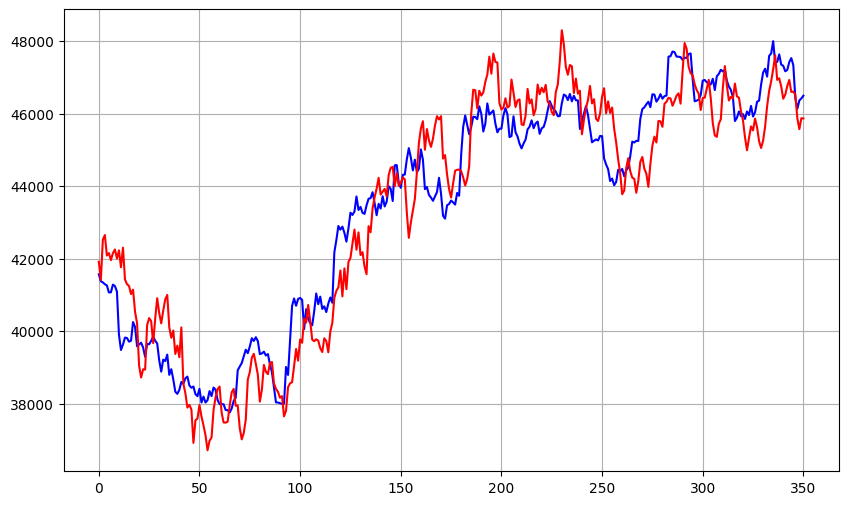

In [62]:
pred_values = model.predict(valid_ds)
plt.figure(figsize=(10, 6))
plt.plot(stock_valid[150:].to_numpy(), label="Actual Validation Data", color="blue")
plt.plot(pred_values*50000, label="Predicted Data", color="red")
plt.grid('on')

# Get the loss and mae from the validation set
valid_loss, valid_mae = model.evaluate(valid_ds)

# Multiply the MAE by 40,000
scaled_mae = valid_mae * 50000

print(f"Scaled MAE: {scaled_mae}")
plt.show()

In [63]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=200):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=8, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 50000

#Simple RNN

In [64]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [65]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.005)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 0.2587 - mae: 0.6934 - val_loss: 0.1389 - val_mae: 0.5249
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1249 - mae: 0.4660 - val_loss: 0.0541 - val_mae: 0.3261
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0541 - mae: 0.2912 - val_loss: 0.0248 - val_mae: 0.2184
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0298 - mae: 0.1999 - val_loss: 0.0144 - val_mae: 0.1641
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0211 - mae: 0.1554 - val_loss: 0.0101 - val_mae: 0.1350
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0174 - mae: 0.1347 - val_loss: 0.0079 - val_mae: 0.1181
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0155 - mae: 0.1246 - val_loss: 0.0068 - val_mae: 0.1077
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0145 - mae: 0.1193 - val_loss: 0.0061 - val_mae: 0.1009
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - l

3600.3269255161285

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0022 - mae: 0.0548
Scaled MAE: 3600.3269255161285


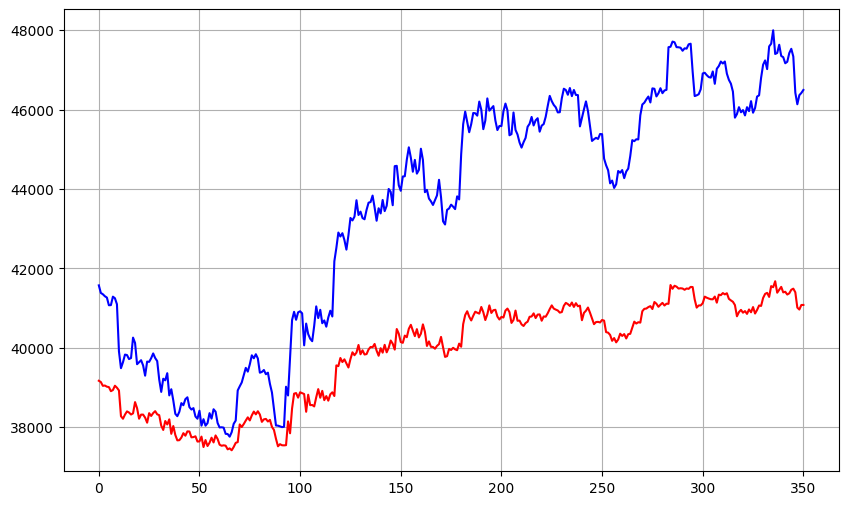

In [66]:
pred_values = model.predict(valid_ds)
plt.figure(figsize=(10, 6))
plt.plot(stock_valid[150:].to_numpy(), label="Actual Validation Data", color="blue")
plt.plot(pred_values*50000, label="Predicted Data", color="red")
plt.grid('on')

# Get the loss and mae from the validation set
valid_loss, valid_mae = model.evaluate(valid_ds)

# Multiply the MAE by 50,000
scaled_mae = valid_mae * 50000

print(f"Scaled MAE: {scaled_mae}")
plt.show()

#More Neurons RNN

In [67]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
more_n_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [68]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(more_n_model, train_ds, valid_ds, learning_rate=0.005)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.3062 - mae: 0.6381 - val_loss: 0.0033 - val_mae: 0.0719
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0078 - mae: 0.1098 - val_loss: 0.0031 - val_mae: 0.0688
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0117 - mae: 0.1314 - val_loss: 0.0053 - val_mae: 0.0969
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0129 - mae: 0.1381 - val_loss: 0.0047 - val_mae: 0.0916
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0114 - mae: 0.1302 - val_loss: 0.0040 - val_mae: 0.0851
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0099 - mae: 0.1214 - val_loss: 0.0036 - val_mae: 0.0800
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0086 - mae: 0.1134 - val_loss: 0.0031 - val_mae: 0.0750
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0075 - mae: 0.1058 - val_loss: 0.0027 - val_mae: 0.0696
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - lo

244.5397898554802

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.4535e-05 - mae: 0.0049
Scaled MAE: 244.5397898554802


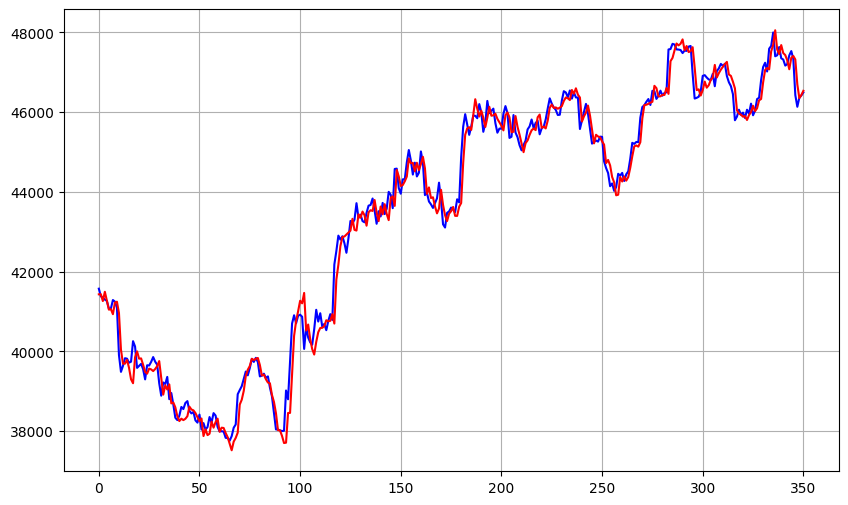

In [69]:
pred_values = more_n_model.predict(valid_ds)
plt.figure(figsize=(10, 6))
plt.plot(stock_valid[150:].to_numpy(), label="Actual Validation Data", color="blue")
plt.plot(pred_values*50000, label="Predicted Data", color="red")
plt.grid('on')

# Get the loss and mae from the validation set
valid_loss, valid_mae = more_n_model.evaluate(valid_ds)

# Multiply the MAE by 50,000
scaled_mae = valid_mae * 50000

print(f"Scaled MAE: {scaled_mae}")
plt.show()

#Deep RNNs

In [70]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [71]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.005)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - loss: 0.2892 - mae: 0.5618 - val_loss: 0.0140 - val_mae: 0.1577
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0515 - mae: 0.2851 - val_loss: 0.0677 - val_mae: 0.3635
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 0.0672 - mae: 0.3148 - val_loss: 0.0104 - val_mae: 0.1330
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 0.0261 - mae: 0.1940 - val_loss: 0.0132 - val_mae: 0.1537
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0285 - mae: 0.2061 - val_loss: 0.0111 - val_mae: 0.1400
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0249 - mae: 0.1910 - val_loss: 0.0100 - val_mae: 0.1332
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - loss: 0.0221 - mae: 0.1793 - val_loss: 0.0088 - val_mae: 0.1262
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 0.0186 - mae: 0.1635 - val_loss: 0.0084 - val_mae: 0.1243
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/

658.942200243473

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.1212e-04 - mae: 0.0129
Scaled MAE: 658.942200243473


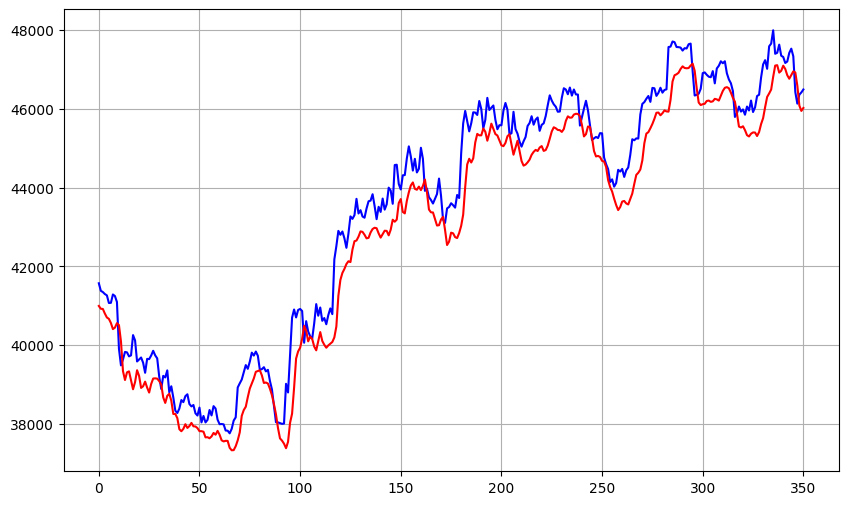

In [72]:
pred_values = deep_model.predict(valid_ds)
plt.figure(figsize=(10, 6))
plt.plot(stock_valid[150:].to_numpy(), label="Actual Validation Data", color="blue")
plt.plot(pred_values*50000, label="Predicted Data", color="red")
plt.grid('on')

# Get the loss and mae from the validation set
valid_loss, valid_mae = deep_model.evaluate(valid_ds)

# Multiply the MAE by 50,000
scaled_mae = valid_mae * 50000

print(f"Scaled MAE: {scaled_mae}")
plt.show()

# Multivariate time series

In [76]:
df_mulvar = df[["Open", "High","Low"]] / 50000  # use both bus & rail series as input
df_mulvar

,Open,High,Low
Datetime,,,
2021-04-30 04:00:00+00:00,1.073880,1.083880,1.073880
2021-04-30 05:00:00+00:00,1.082645,1.086200,1.078818
2021-04-30 06:00:00+00:00,1.085184,1.088574,1.083750
2021-04-30 07:00:00+00:00,1.088674,1.090017,1.085528
2021-04-30 08:00:00+00:00,1.087047,1.092395,1.083066
...,...,...,...
2023-04-30 00:00:00+00:00,0.584910,0.584943,0.583386
2023-04-30 01:00:00+00:00,0.583191,0.583571,0.582517
2023-04-30 02:00:00+00:00,0.582280,0.583942,0.582280


In [83]:
# Assuming df is your DataFrame and DateTime is already the index
stock_train = df_mulvar[:"2021-07-26 01:00:00+00:00"]
stock_valid = df_mulvar["2021-07-26 01:00:00+00:00":"2021-08-16 18:00:00+00:00"]
stock_test = df_mulvar["2021-08-16 18:00:00+00:00":"2021-09-07 10:00:00+00:00"]

# # Convert the Series to Numpy arrays
# train_data = stock_train.values
# valid_data = stock_valid.values
# test_data = stock_test.values

In [84]:
stock_train

,Open,High,Low
Datetime,,,
2021-04-30 04:00:00+00:00,1.073880,1.083880,1.073880
2021-04-30 05:00:00+00:00,1.082645,1.086200,1.078818
2021-04-30 06:00:00+00:00,1.085184,1.088574,1.083750
2021-04-30 07:00:00+00:00,1.088674,1.090017,1.085528
2021-04-30 08:00:00+00:00,1.087047,1.092395,1.083066
...,...,...,...
2021-07-25 20:00:00+00:00,0.687225,0.689261,0.686394
2021-07-25 21:00:00+00:00,0.688806,0.691443,0.688346
2021-07-25 22:00:00+00:00,0.690940,0.691512,0.689456


In [90]:
# Define the parameters
sequence_length = 150  # This is the length of the sequences (timesteps)
batch_size = 80  # Number of samples per batch

# Creating time series datasets from the data arrays
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=stock_train.to_numpy(),
    targets=stock_train["Open"][sequence_length:],
    sequence_length=sequence_length,
    batch_size=batch_size
)

valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=stock_valid.to_numpy(),
    targets=stock_valid["Open"][sequence_length:],
    sequence_length=sequence_length,
    batch_size=batch_size
)


In [91]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 3]),
    tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [92]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.005)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0740 - mae: 0.3167 - val_loss: 0.0033 - val_mae: 0.0807
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0039 - mae: 0.0752 - val_loss: 3.4697e-04 - val_mae: 0.0231
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0011 - mae: 0.0414 - val_loss: 8.6025e-05 - val_mae: 0.0112
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0015 - mae: 0.0462 - val_loss: 5.8266e-05 - val_mae: 0.0091
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0012 - mae: 0.0420 - val_loss: 5.2063e-05 - val_mae: 0.0082
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 9.1560e-04 - mae: 0.0370 - val_loss: 5.6660e-05 - val_mae: 0.0084
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 7.4831e-04 - mae: 0.0333 - val_loss: 6.1900e-05 - val_mae: 0.0089
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 6.3736e-04 - mae: 0.0306 - val_loss: 6.7869e-05 - val_mae: 0.0094
Epoch 9/200
24/2

411.98418475687504

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.7245e-05 - mae: 0.0096
Scaled MAE: 411.98418475687504


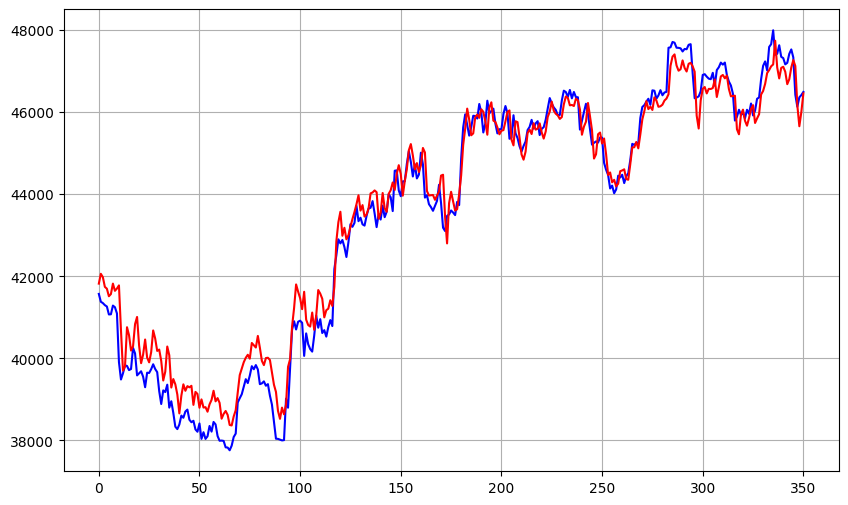

In [98]:
pred_values = mulvar_model.predict(valid_mulvar_ds)
plt.figure(figsize=(10, 6))
plt.plot(stock_valid["Open"][150:].to_numpy()*50000, label="Actual Validation Data", color="blue")
plt.plot(pred_values*50000, label="Predicted Data", color="red")
plt.grid('on')

# Get the loss and mae from the validation set
valid_loss, valid_mae = mulvar_model.evaluate(valid_mulvar_ds)

# Multiply the MAE by 50,000
scaled_mae = valid_mae * 50000

print(f"Scaled MAE: {scaled_mae}")
plt.show()

In [96]:
pred_values*50000

array([[41821.074],
       [42060.96 ],
       [41979.215],
       [41742.652],
       [41697.746],
       [41513.965],
       [41566.445],
       [41821.777],
       [41645.953],
       [41701.562],
       [41778.324],
       [40685.55 ],
       [39699.69 ],
       [39802.95 ],
       [40758.09 ],
       [40565.41 ],
       [40189.5  ],
       [40293.58 ],
       [40835.03 ],
       [41009.19 ],
       [40317.47 ],
       [39880.965],
       [40091.523],
       [40458.67 ],
       [40018.836],
       [39902.17 ],
       [40149.215],
       [40679.613],
       [40482.746],
       [40180.82 ],
       [40213.223],
       [39937.65 ],
       [39459.953],
       [39673.676],
       [40287.57 ],
       [40075.598],
       [39288.152],
       [39494.773],
       [39366.74 ],
       [39117.867],
       [38657.5  ],
       [39090.3  ],
       [39366.46 ],
       [39208.965],
       [39322.367],
       [39293.055],
       [39330.273],
       [38865.457],
       [39181.926],
       [39131.79 ],
